In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torchvision import transforms, models, datasets
import numpy as np
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import os
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from collections import OrderedDict

In [35]:
labels_csv = {'train': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"
             }
data_dir = {'train': "/scratch/scratch6/akansh12/DeepEXrays/data/data_1024/train/",
           'test': "/scratch/scratch6/akansh12/DeepEXrays/data/data_1024/test/"}

In [36]:
#dataset
class Vin_big_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transforms, data_type, selec_radio, radio_id = None):
        global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
        
        if data_type == 'train':
            label_df = pd.read_csv(label_loc)
            if selec_radio == 'rand_one':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames = np.unique(label_df.index.values).tolist()
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
                self.labels = []
                for i in (filenames):
                    self.labels.append(label_df[global_labels].loc[i].values.tolist()[np.random.choice([0,1,2])])
                self.labels = torch.tensor(self.labels)
            if selec_radio == 'agree_two':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames_temp = np.unique(label_df.index.values).tolist()
                self.labels = []
                filenames = []
                for i in filenames_temp:
                    a,b = np.unique(label_df.loc[i][global_labels].values, axis = 0, return_counts=True)
                    if b[0] >= 2:
                        filenames.append(i)
                        self.labels.append(a[0])
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'agree_three':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames_temp = np.unique(label_df.index.values).tolist()
                self.labels = []
                filenames = []
                for i in filenames_temp:
                    a,b = np.unique(label_df.loc[i][global_labels].values, axis = 0, return_counts=True)
                    if b[0] == 3:
                        filenames.append(i)
                        self.labels.append(a[0])
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'radio_per_epoch':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames = np.unique(label_df.index.values).tolist()
                self.labels = []
                for i in filenames:
                    self.labels.append(label_df.loc[i][global_labels].values[radio_id].tolist())
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'all': 
                label_df['labels'] = label_df['image_id'] +'_'+ label_df['rad_id']
                label_df.set_index("labels", inplace = True)
                filenames = label_df.index.values.tolist()
            
                self.full_filenames = [os.path.join(image_loc, i.split('_')[0]+'.png') for i in filenames]
                self.labels = []
                for i in tqdm(filenames):
                    self.labels.append(label_df[global_labels].loc[i].values.tolist())         
                self.labels = torch.tensor(self.labels)
                
        if data_type == 'test':                     
            filenames = os.listdir(image_loc)
            self.full_filenames = [os.path.join(image_loc, i) for i in filenames]
            label_df = pd.read_csv(label_loc)
            label_df.set_index("image_id", inplace = True)
            self.labels = [label_df[global_labels].loc[filename[:-4]].values for filename in filenames]
            
        self.transforms = transforms
#         self.data_type = data_type
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transforms(image)
        
        return image, self.labels[idx]
    
            

In [37]:
data_transforms = { 
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(p = 0.5), 
        transforms.RandomPerspective(distortion_scale=0.3),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])        
    ])
    
}
test_dataset = Vin_big_dataset(image_loc = data_dir['test'],
                          label_loc = labels_csv['test'],
                          transforms = data_transforms['test'],
                          data_type = 'test', selec_radio = None)
testloader = DataLoader(test_dataset,batch_size = 8,shuffle = False)

In [40]:
model = models.densenet201(pretrained=False)
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1920,6)),
    ('out', nn.Sigmoid()),
]))

state_dict = torch.load("/scratch/scratch6/akansh12/DeepEXrays/model/0.927723_.pth", map_location = 'cpu')['state_dict']
for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())

model.load_state_dict(state_dict)

<All keys matched successfully>

### Saliency Map

In [ ]:
model.eval()
predicted = []
for images,labels in tqdm(testloader):
    ps = model(images)
    predicted.extend(ps.tolist())

  0%|          | 0/375 [00:00<?, ?it/s]

In [ ]:
roc_auc_score(testloader.dataset.labels, np.array(predicted), average=None)

In [31]:
roc_auc_score(testloader.dataset.labels, np.array(predicted), average=None)

array([0.98090926, 0.86865154, 0.92951863, 0.91878806, 0.88830812,
       0.92824673])

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc

fpr, tpr, thresholds =  roc_curve(np.array(testloader.dataset.labels)[:,0], np.array(predicted)[:,0])

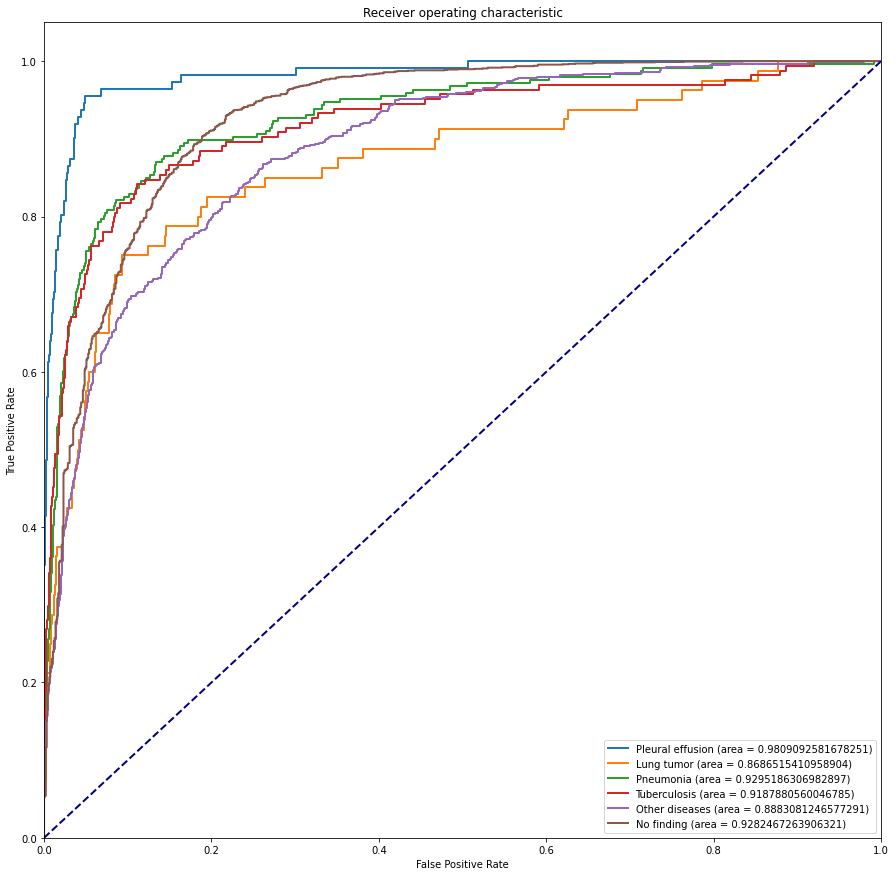

In [34]:
plt.figure(figsize=(15,15))
lw = 2
global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
for i,j in enumerate(global_labels):
    fpr, tpr, thresholds =  roc_curve(np.array(testloader.dataset.labels)[:,i], np.array(predicted)[:,i])
    plt.plot(fpr,tpr,lw=lw,label=f"{global_labels[i]} (area = {auc(fpr,tpr)})")
    
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()
